In [1]:
import pandas as pd

from torch.utils.data import DataLoader
from torch import nn
import torch

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import optuna

from create_dataset import CreateDataset
from train_models import RegressorTrainer

In [2]:
df = pd.read_csv('data/ConcreteStrengthData.csv')

In [3]:
df

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [4]:
X = df.drop(columns=['Strength'])
y = df['Strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((824, 8), (206, 8), (824,), (206,))

In [5]:
train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=40,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=40,
                              num_workers=0
                             )

In [6]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden1 = trial.suggest_int("hidden1", 64, 512)
    hidden2 = trial.suggest_int("hidden2", 32, hidden1)
    hidden3 = trial.suggest_int("hidden3", 16, hidden2)

    class LinearModel(nn.Module):
        def __init__(self, in_dim, out_dim=1):
            super().__init__()
            self.features = nn.Sequential(
                nn.Linear(in_dim, hidden1),
                nn.ReLU(),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Linear(hidden2, hidden3),
                nn.ReLU(),
                nn.Linear(hidden3, out_dim),
            )
        def forward(self, x):
            return self.features(x)

    model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    trainer = RegressorTrainer(model=model,
                                criterion=criterion,
                                optimizer=optimizer,
                                device='cpu')

    trainer.fit(train_dataloader,
                test_dataloader,
                num_epoch=20,
                info_every_iter=20,
                show_val_metrics=False)

    return trainer.metrics['train_loss'][-1]

In [7]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

[I 2025-05-02 14:24:54,669] A new study created in memory with name: no-name-e134300f-95a9-4dc5-88fb-aa76f109cb45


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-02 14:24:55,237] Trial 0 finished with value: 209.50488770123823 and parameters: {'lr': 0.00010602865470781065, 'hidden1': 347, 'hidden2': 234, 'hidden3': 54}. Best is trial 0 with value: 209.50488770123823.


Epoch [20/20] Train Loss: 209.5049 MSE: 209.5049 MAE: 11.7340 RMSE: 14.4743


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-02 14:24:55,702] Trial 1 finished with value: 202.5613855158241 and parameters: {'lr': 0.0001946975423564747, 'hidden1': 382, 'hidden2': 81, 'hidden3': 31}. Best is trial 1 with value: 202.5613855158241.


Epoch [20/20] Train Loss: 202.5614 MSE: 202.5614 MAE: 11.5626 RMSE: 14.2324


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-02 14:24:56,338] Trial 2 finished with value: 780.6761602012856 and parameters: {'lr': 2.2513746730038754e-05, 'hidden1': 483, 'hidden2': 397, 'hidden3': 70}. Best is trial 1 with value: 202.5613855158241.


Epoch [20/20] Train Loss: 780.6762 MSE: 780.6761 MAE: 23.2330 RMSE: 27.9406


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-02 14:24:56,831] Trial 3 finished with value: 35.43274046147911 and parameters: {'lr': 0.001667048123566414, 'hidden1': 238, 'hidden2': 187, 'hidden3': 80}. Best is trial 3 with value: 35.43274046147911.


Epoch [20/20] Train Loss: 35.4327 MSE: 35.4327 MAE: 4.5380 RMSE: 5.9525


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-02 14:24:57,292] Trial 4 finished with value: 1329.184616533298 and parameters: {'lr': 2.229475069975762e-05, 'hidden1': 169, 'hidden2': 135, 'hidden3': 122}. Best is trial 3 with value: 35.43274046147911.


Epoch [20/20] Train Loss: 1329.1846 MSE: 1329.1846 MAE: 32.4406 RMSE: 36.4580


In [8]:
print("Best trial:")
print(study.best_trial.params)

Best trial:
{'lr': 0.001667048123566414, 'hidden1': 238, 'hidden2': 187, 'hidden3': 80}


In [9]:
class Model(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 144),
            torch.nn.ReLU(),
            
            nn.Linear(144, 72),
            torch.nn.ReLU(),
            
            nn.Linear(72, 72),
            torch.nn.ReLU(),
            
            nn.Linear(72, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output
    

model = Model(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)


trainer = RegressorTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=20,
            info_every_iter=True,
            show_val_metrics=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] Train Loss: 1334.3108 MSE: 1334.3108 MAE: 32.3772 RMSE: 36.5282
Epoch [1/20] Val Loss: 701.8810 MSE: 701.8810 MAE: 22.3535 RMSE: 26.4930
Epoch [2/20] Train Loss: 352.2505 MSE: 352.2505 MAE: 14.5335 RMSE: 18.7683
Epoch [2/20] Val Loss: 199.7044 MSE: 199.7044 MAE: 11.5673 RMSE: 14.1317
Epoch [3/20] Train Loss: 217.1559 MSE: 217.1559 MAE: 11.9266 RMSE: 14.7362
Epoch [3/20] Val Loss: 182.3465 MSE: 182.3465 MAE: 10.8729 RMSE: 13.5036
Epoch [4/20] Train Loss: 197.2647 MSE: 197.2647 MAE: 11.3766 RMSE: 14.0451
Epoch [4/20] Val Loss: 154.7408 MSE: 154.7408 MAE: 10.3975 RMSE: 12.4395
Epoch [5/20] Train Loss: 170.4709 MSE: 170.4709 MAE: 10.6336 RMSE: 13.0564
Epoch [5/20] Val Loss: 144.9379 MSE: 144.9379 MAE: 10.0019 RMSE: 12.0390
Epoch [6/20] Train Loss: 157.0530 MSE: 157.0530 MAE: 10.1891 RMSE: 12.5321
Epoch [6/20] Val Loss: 138.5297 MSE: 138.5297 MAE: 9.6655 RMSE: 11.7699
Epoch [7/20] Train Loss: 146.9975 MSE: 146.9975 MAE: 9.8516 RMSE: 12.1243
Epoch [7/20] Val Loss: 130.9945 MSE: 

In [10]:
model = trainer.model

In [11]:
model.eval()

Model(
  (features): Sequential(
    (0): Linear(in_features=8, out_features=144, bias=True)
    (1): ReLU()
    (2): Linear(in_features=144, out_features=72, bias=True)
    (3): ReLU()
    (4): Linear(in_features=72, out_features=72, bias=True)
    (5): ReLU()
    (6): Linear(in_features=72, out_features=1, bias=True)
  )
)

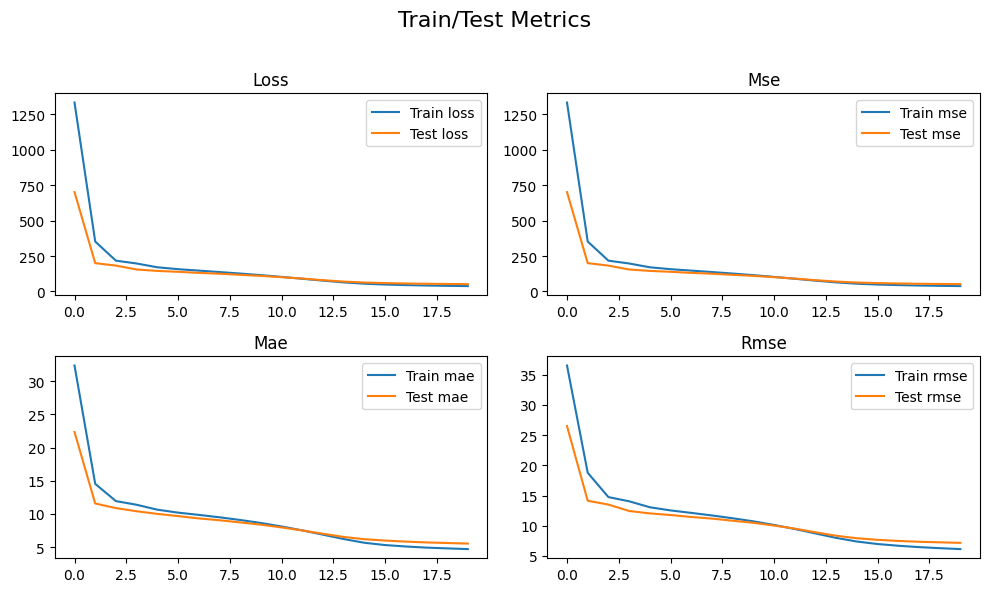

In [13]:
trainer.plot_metrics()

In [12]:
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        predictions = model(X_batch).squeeze()
        
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.8011
MSE: 51.2645
MAE: 5.5224
